t=  0.00 hours: v min/max  -2.42,   2.34 theta min/max -49.81,  17.59
t=  0.50 hours: v min/max  -2.44,   2.28 theta min/max -49.81,  17.59
t=  1.00 hours: v min/max  -2.48,   2.25 theta min/max -49.81,  17.59
t=  1.50 hours: v min/max  -2.53,   2.22 theta min/max -49.81,  17.59
t=  2.00 hours: v min/max  -2.57,   2.19 theta min/max -49.81,  17.59
t=  2.50 hours: v min/max  -2.60,   2.16 theta min/max -49.81,  17.59
t=  3.00 hours: v min/max  -2.62,   2.14 theta min/max -49.81,  17.59
t=  3.50 hours: v min/max  -2.64,   2.12 theta min/max -49.81,  17.59
t=  4.00 hours: v min/max  -2.68,   2.12 theta min/max -49.81,  17.59
t=  4.50 hours: v min/max  -2.71,   2.12 theta min/max -49.81,  17.59
t=  5.00 hours: v min/max  -2.74,   2.12 theta min/max -49.81,  17.59
t=  5.50 hours: v min/max  -2.77,   2.12 theta min/max -49.81,  17.59
t=  6.00 hours: v min/max  -2.80,   2.12 theta min/max -49.81,  17.59
t=  6.50 hours: v min/max  -2.83,   2.11 theta min/max -49.81,  17.59
t=  7.00 hours: v mi

t= 65.50 hours: v min/max -29.62,  25.60 theta min/max -49.81,  17.59
t= 66.00 hours: v min/max -30.20,  26.44 theta min/max -49.81,  17.59
t= 66.50 hours: v min/max -30.73,  27.24 theta min/max -49.81,  17.60
t= 67.00 hours: v min/max -31.32,  28.00 theta min/max -49.81,  17.60
t= 67.50 hours: v min/max -32.20,  28.73 theta min/max -49.81,  17.60
t= 68.00 hours: v min/max -33.04,  29.41 theta min/max -49.81,  17.60
t= 68.50 hours: v min/max -33.84,  30.03 theta min/max -49.81,  17.60
t= 69.00 hours: v min/max -34.60,  30.60 theta min/max -49.81,  17.60
t= 69.50 hours: v min/max -35.30,  31.52 theta min/max -49.81,  17.60
t= 70.00 hours: v min/max -35.95,  32.50 theta min/max -49.81,  17.60
t= 70.50 hours: v min/max -36.53,  33.43 theta min/max -49.81,  17.60
t= 71.00 hours: v min/max -37.05,  34.31 theta min/max -49.81,  17.60
t= 71.50 hours: v min/max -37.97,  35.13 theta min/max -49.81,  17.60
t= 72.00 hours: v min/max -38.90,  35.88 theta min/max -49.81,  17.60
t= 72.50 hours: v mi

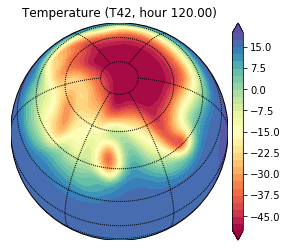

In [2]:
from __future__ import print_function
import numpy as np
from spharm import Spharmt, getspecindx, gaussian_lats_wts

# two-level baroclinic primitive equation model of
# Lee, S. and I. M. Held: 1993: Baroclinic Wave Packets in Models and Observations
# J. Atmos. Sci., 50, 1413-1428.
# http://dx.doi.org/10.1175/1520-0469(1993)050<1413:BWPIMA>2.0.CO;2

class TwoLevel(object):

    def __init__(self,sp,dt,ntrunc,ptop=0.,p0=1.e5,grav=9.80616,omega=7.292e-5,cp=1004,\
            rgas=287.,efold=3600.,ndiss=8,tdrag=1.e30,tdiab=1.e30,\
            umax=40,jetexp=2,delth=20,moistfact=1.0):
        # set model parameters
        self.p0 = p0 # mean surface pressure
        self.ptop = ptop # model top pressure
        self.rgas = rgas # gas constant for dry air
        self.grav = grav # gravity
        self.omega = omega # rotation rate
        self.cp = cp # specific heat of dry air at constant pressure
        self.delth = delth # static stability
        # factor to reduce static stability in rising air
        # (crude moist physics assuming air is saturated)
        # moistfact = 1 is dry model
        self.moistfact = moistfact
        dp = 0.5*(ptop-p0)
        exnf1 = cp*((p0+0.5*dp)/p0)**(rgas/cp)
        exnf2 = cp*((p0+1.5*dp)/p0)**(rgas/cp)
        self.delta_exnf = exnf2-exnf1 # diff in exner function between 2 levs.
        # efolding time scale for hyperdiffusion at shortest wavenumber
        self.efold = efold
        self.ndiss = ndiss # order of hyperdiffusion (2 for laplacian)
        self.sp = sp # Spharmt instance
        self.ntrunc = ntrunc # triangular truncation wavenumber
        self.dt = dt # time step (secs)
        self.tdiab = tdiab # lower layer drag timescale
        self.tdrag = tdrag # interface relaxation timescale
        # create lat/lon arrays
        delta = 2.*np.pi/sp.nlon
        if sp.gridtype == 'regular':
           lats1d = 0.5*np.pi-delta*np.arange(sp.nlat)
           wts = np.cos(lats1d)
        else:
           lats1d,wts = gaussian_lats_wts(sp.nlat)
           lats1d = lats1d*np.pi/180. # convert to radians.
        lons1d = np.arange(-np.pi,np.pi,delta)
        lons,lats = np.meshgrid(lons1d,lats1d)
        self.lons = lons; self.lats = lats
        # weights for computing global means.
        self.globalmeanwts = np.ones((sp.nlat,sp.nlon))*wts[:,np.newaxis]
        self.globalmeanwts = self.globalmeanwts/self.globalmeanwts.sum()
        self.f = 2.*omega*np.sin(lats)[:,:,np.newaxis] # coriolis
        # create laplacian operator and its inverse.
        indxm, indxn = getspecindx(ntrunc)
        indxn = indxn.astype(np.float32)
        totwavenum = indxn*(indxn+1.0)
        self.lap = -totwavenum/sp.rsphere**2
        self.ilap = np.zeros(self.lap.shape, np.float32)
        self.ilap[1:] = 1./self.lap[1:]
        # hyperdiffusion operator
        self.hyperdiff = -(1./efold)*(totwavenum/totwavenum[-1])**(ndiss/2)
        # set equilibrium layer thicknes profile.
        self._interface_profile(umax,jetexp)

    def _interface_profile(self,umax,jetexp):
        ug = np.zeros((self.sp.nlat,self.sp.nlon,2),np.float32)
        vg = np.zeros((self.sp.nlat,self.sp.nlon,2),np.float32)
        ug[:,:,1] = umax*np.sin(2.*self.lats)**jetexp
        vrtspec, divspec = self.sp.getvrtdivspec(ug,vg,self.ntrunc)
        thetaspec = self.nlbalance(vrtspec)
        self.thetaref = self.sp.spectogrd(thetaspec)
        self.uref = ug

    def nlbalance(self,vrtspec):
        # solve nonlinear balance eqn to get potential temp given vorticity.
        vrtg = self.sp.spectogrd(vrtspec)
        divspec2 = np.zeros(vrtspec.shape, vrtspec.dtype)
        ug,vg = self.sp.getuv(vrtspec,divspec2)
        # horizontal vorticity flux
        tmpg1 = ug*(vrtg+self.f); tmpg2 = vg*(vrtg+self.f)
        # compute vort flux contributions to vorticity and divergence tend.
        tmpspec, dvrtdtspec = self.sp.getvrtdivspec(tmpg1,tmpg2,self.ntrunc)
        ddivdtspec = tmpspec[:,1]-tmpspec[:,0]
        ke = 0.5*(ug**2+vg**2)
        tmpspec = self.sp.grdtospec(ke[:,:,1]-ke[:,:,0],self.ntrunc)
        return (tmpspec - self.ilap*ddivdtspec)/self.delta_exnf

    def gettend(self,vrtspec,divspec,thetaspec):
        # compute tendencies.
        # first, transform fields from spectral space to grid space.
        vrtg = self.sp.spectogrd(vrtspec)
        # this is baroclinic div = divupper-divlower
        # omega = dp*divg/2
        # baroptropic div is zero.
        divg = self.sp.spectogrd(divspec)
        divspec2 = np.empty(vrtspec.shape, vrtspec.dtype)
        divspec2[:,0] = -0.5*divspec
        divspec2[:,1] = 0.5*divspec
        ug,vg = self.sp.getuv(vrtspec,divspec2)
        thetag = self.sp.spectogrd(thetaspec)
        self.u = ug; self.v = vg; self.divg = divg
        self.vrt = vrtg; self.theta = thetag
        vadvu = 0.25*(divg*(ug[:,:,1]-ug[:,:,0]))
        vadvv = 0.25*(divg*(vg[:,:,1]-vg[:,:,0]))
        # horizontal vorticity flux
        tmpg1 = ug*(vrtg+self.f); tmpg2 = vg*(vrtg+self.f)
        # add lower layer drag and vertical advection contributions
        tmpg1[:,:,0] += vadvv + vg[:,:,0]/self.tdrag
        tmpg2[:,:,0] += -vadvu - ug[:,:,0]/self.tdrag
        tmpg1[:,:,1] += vadvv
        tmpg2[:,:,1] += -vadvu
        # compute vort flux contributions to vorticity and divergence tend.
        tmpspec, dvrtdtspec = self.sp.getvrtdivspec(tmpg1,tmpg2,self.ntrunc)
        ddivdtspec = tmpspec[:,1]-tmpspec[:,0]
        dvrtdtspec *= -1
        # vorticity hyperdiffusion
        dvrtdtspec += self.hyperdiff[:,np.newaxis]*vrtspec
        # add laplacian term and hyperdiffusion to div tend.
        ke = 0.5*(ug**2+vg**2)
        tmpspec = self.sp.grdtospec(ke[:,:,1]-ke[:,:,0],self.ntrunc)
        ddivdtspec += self.hyperdiff*divspec - \
                      self.lap*(tmpspec - self.delta_exnf*thetaspec)
        # horizontal gradient of pot. temp.
        thetagradx, thetagrady = self.sp.getgrad(thetaspec)
        # tendency of pot. temp.
        vadvtheta = 0.5*divg*self.delth
        # in rising air, use reduced static stability
        if self.moistfact < 1:
            wmean = ((divg + np.abs(divg))*self.globalmeanwts).sum()
            # need to remove global mean vertical velocity or
            # global mean temp will increase.
            self.heat = 0.25*(divg + np.abs(divg) - wmean)*self.delth*(1.-self.moistfact)
        else: # moistfact=1 is dry model
            self.heat = np.zeros(self.theta.shape, self.theta.dtype)
        umean = 0.5*(ug[:,:,1]+ug[:,:,0])
        vmean = 0.5*(vg[:,:,1]+vg[:,:,0])
        # advection
        tmpg = -umean*thetagradx - vmean*thetagrady - vadvtheta
        # thermal relaxation term.
        tmpg += (self.thetaref-thetag)/self.tdiab
        # heating term.
        tmpg += self.heat
        dthetadtspec = self.sp.grdtospec(tmpg, self.ntrunc)
        # hyperdiffusion
        dthetadtspec += self.hyperdiff*thetaspec
        return dvrtdtspec,ddivdtspec,dthetadtspec

    def rk4step(self,vrtspec,divspec,thetaspec):
        # update state using 4th order runge-kutta
        dt = self.dt
        k1vrt,k1div,k1thk = \
        self.gettend(vrtspec,divspec,thetaspec)
        k2vrt,k2div,k2thk = \
        self.gettend(vrtspec+0.5*dt*k1vrt,divspec+0.5*dt*k1div,thetaspec+0.5*dt*k1thk)
        k3vrt,k3div,k3thk = \
        self.gettend(vrtspec+0.5*dt*k2vrt,divspec+0.5*dt*k2div,thetaspec+0.5*dt*k2thk)
        k4vrt,k4div,k4thk = \
        self.gettend(vrtspec+dt*k3vrt,divspec+dt*k3div,thetaspec+dt*k3thk)
        vrtspec += dt*(k1vrt+2.*k2vrt+2.*k3vrt+k4vrt)/6.
        divspec += dt*(k1div+2.*k2div+2.*k3div+k4div)/6.
        thetaspec += dt*(k1thk+2.*k2thk+2.*k3thk+k4thk)/6.
        return vrtspec,divspec,thetaspec

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from mpl_toolkits.basemap import Basemap, addcyclic

    # grid, time step info
    nlons = 128  # number of longitudes
    ntrunc = 42 # spectral truncation (for alias-free computations)
    nlats = (nlons/2)+1 # for regular grid.
    gridtype = 'regular'
    #nlats = nlons/2 # for gaussian grid.
    #gridtype = 'gaussian'
    dt = 1800 # time step in seconds
    itmax = int(5*(86400/dt)) # integration length in days
    umax = 50. # jet speed
    jetexp = 6 # parameter controlling jet width

    # create spherical harmonic instance.
    rsphere = 6.37122e6 # earth radius
    sp = Spharmt(nlons,nlats,rsphere=rsphere,gridtype=gridtype)

    # create model instance using default parameters.
    model = TwoLevel(sp,dt,ntrunc)

    # vort, div initial conditions
    psipert = np.zeros((sp.nlat,sp.nlon,2),np.float32)
    psipert[:,:,1] = 5.e6*np.sin((model.lons-np.pi))**12*np.sin(2.*model.lats)**12
    psipert = np.where(model.lons[:,:,np.newaxis] > 0., 0, psipert)
    ug = np.zeros((sp.nlat,sp.nlon,2),np.float32)
    vg = np.zeros((sp.nlat,sp.nlon,2),np.float32)
    ug[:,:,1] = umax*np.sin(2.*model.lats)**jetexp
    vrtspec, tmpspec = sp.getvrtdivspec(ug,vg,model.ntrunc)
    vrtspec = vrtspec + model.lap[:,np.newaxis]*sp.grdtospec(psipert,model.ntrunc)
    thetaspec = model.nlbalance(vrtspec)
    divspec = np.zeros(thetaspec.shape, thetaspec.dtype)

    # time loop.
    for ncycle in range(itmax+1):
        t = ncycle*model.dt
        vrtspec, divspec, thetaspec = model.rk4step(vrtspec, divspec, thetaspec)
        print('t=%6.2f hours: v min/max %6.2f, %6.2f theta min/max %6.2f, %6.2f'%\
        (t/3600.,model.v.min(), model.v.max(), model.theta.min(),
            model.theta.max()))

    # make a plot of temperature
    m = Basemap(projection='ortho',lat_0=60,lon_0=90)
    lons1d = model.lons[0,:]*180./np.pi
    lats1d = model.lats[:,0]*180./np.pi
    thetag,lons1dx = addcyclic(model.theta,lons1d)
    lons, lats = np.meshgrid(lons1dx,lats1d)
    x,y = m(lons,lats)
    m.drawmeridians(np.arange(-180,180,60))
    m.drawparallels(np.arange(-80,81,20))
    CS=m.contourf(x,y,thetag,30,cmap=plt.cm.get_cmap("Spectral"),extend='both')
    m.colorbar()
    plt.title('Temperature (T%s, hour %6.2f)' % (ntrunc,t/3600.))
    plt.show()